# Regexsynth code efficiency & finding bottleneck
---

In [1]:
import json
import matplotlib.pyplot as plt

In [2]:
# open file and read data
f = open("flamegraph.json")
data = json.load(f)[0]
synth = data['spans'][0]

## Parsing data

In [3]:
# create dict to store time stats
funcs = ['update_parentheses', 'is_inside_or',
         'match_all', 'match_none', 'extend', 'is_dead', 
         'is_redundant', 'split', 'unroll', 'find_parentheses']
times_called = {k: 0 for k in funcs}
stats = {k: 0 for k in funcs}
stats['synth'] = synth['delta']

In [4]:
# a summation of time of all functions called
def recursive_add_time(function):
    # dict_keys(['name', 'start_ns', 'end_ns', 'delta', 'depth', 'children', 'notes'])
    if function['children']:
        for subfunctions in function['children']:
            func_name = subfunctions['name']
            func_time = subfunctions['delta']
            stats[func_name] += func_time
            times_called[func_name] += 1 
            recursive_add_time(subfunctions)


recursive_add_time(synth)
print(stats)

{'update_parentheses': 4224426, 'is_inside_or': 6492742, 'match_all': 1786280064, 'match_none': 7893420744, 'extend': 46637233, 'is_dead': 2675822233, 'is_redundant': 7084289887, 'split': 24598693, 'unroll': 25000758, 'find_parentheses': 18648721, 'synth': 9842655709}


## Visualize

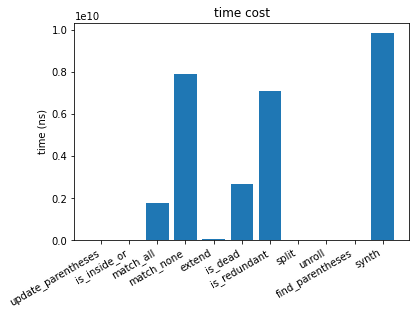

In [5]:
# draw plot
fig, ax = plt.subplots()
ax.bar(stats.keys(), stats.values())
ax.set_ylabel('time (ns)')
ax.set_title('time cost')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()
# fig.tight_layout()

In [6]:
ratio_of_each = {k:round(v/stats['synth'], 2) for (k,v) in stats.items()}
"""
extend + matchall + matchnone = 0.97 synth
"""
ratio_of_each
"""
{'update_parentheses': 0.08,
 'is_inside_or': 0.1,
 'match_all': 0.04,
 'match_none': 0.0,
 'extend': 0.91,
 'is_duplicate': 0.18,
 'insert_table': 0.11,
 'push': 0.03,
 'find_occurrences': 0.02,
 'init_state': 0.05,
 'synth': 1.0}
"""
ratio_of_each


{'update_parentheses': 0.0,
 'is_inside_or': 0.0,
 'match_all': 0.18,
 'match_none': 0.8,
 'extend': 0.0,
 'is_dead': 0.27,
 'is_redundant': 0.72,
 'split': 0.0,
 'unroll': 0.0,
 'find_parentheses': 0.0,
 'synth': 1.0}

In [7]:
"""
{'update_parentheses': 2231460,
 'is_inside_or': 2231460,
 'match_all': 1128,
 'match_none': 147,
 'extend': 116782,
 'is_duplicate': 2231460,
 'insert_table': 884406,
 'push': 884406,
 'find_occurrences': 116782,
 'init_state': 884406}
"""
times_called

{'update_parentheses': 15510,
 'is_inside_or': 15510,
 'match_all': 3577,
 'match_none': 16309,
 'extend': 3102,
 'is_dead': 3414,
 'is_redundant': 3224,
 'split': 3224,
 'unroll': 3224,
 'find_parentheses': 6448}

In [8]:
"""
{'update_parentheses': 237.05256155162988,
 'is_inside_or': 296.4919505615158,
 'match_all': 206824.1329787234,
 'match_none': 105825.6530612245,
 'extend': 49671.88202805227,
 'is_duplicate': 505.50786480600146,
 'insert_table': 771.1694097507253,
 'push': 200.43621255396278,
 'find_occurrences': 846.6527547053485,
 'init_state': 335.48012677435474}
"""
# del times_called['find_occurrences']
avg_execution_time_per_call_ns = {k: stats[k]/v for k, v in times_called.items()}
avg_execution_time_per_call_ns


{'update_parentheses': 272.3678916827853,
 'is_inside_or': 418.61650548033526,
 'match_all': 499379.38607771875,
 'match_none': 483991.70666503155,
 'extend': 15034.568987749839,
 'is_dead': 783779.2129466902,
 'is_redundant': 2197360.3867866006,
 'split': 7629.867555831265,
 'unroll': 7754.577543424318,
 'find_parentheses': 2892.171370967742}

In [21]:
stats

{'update_parentheses': 14252853,
 'is_inside_or': 17565009,
 'match_all': 217798756,
 'match_none': 15119751,
 'extend': 192483182,
 'is_duplicate': 24016151,
 'insert_table': 40735914,
 'push': 10858652,
 'find_occurrences': 0,
 'init_state': 18832416,
 'synth': 444007167}

In [7]:
print((stats['is_inside_or']+stats['update_parentheses']+stats['is_duplicate']+stats['insert_table']+stats['push']+stats['init_state'])/stats['extend'])
# print(stats['extend'])

0.5989879398197877


In [ ]:
print("find_parentheses/is_inside_or = ", round(stats['find_parentheses']/stats['is_inside_or'], 2))
print("is_inside_or/extend = ", round(stats['is_inside_or']/stats['extend'], 2))


In [38]:
stats['find_occurrences']

1016804

## Time efficiency of state processing

### todo:
* 確認 pruning 正確性 from that case
* prune太少是不是有可以砍的case沒有考慮
* 開over approx再測一次
* 統計is_dead/is_redundant各砍了多少
* -----
* split/unroll efficiency
* is_redundant正確性 (超過九還沒找到答案8)
* find_parentheses/unroll時間佔比

### 可能原因
* 可以長出正確答案的state被prune掉了 應該是pruning的機制裡面出了些問題
* 需要再確定是dead還是redundant
* match_none call一次的時間大約是0.0004秒 但呼叫一萬多次所以加起來接近八秒

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('stats.csv')
df = df.set_index('cost')
df.head()

,sec,state_num
cost,,
1,0.000640,2
2,0.001508,7
3,0.002952,22
4,0.006615,83
5,0.015361,322


In [3]:
df2 = pd.read_csv('stats_remove.csv')
df2 = df2.set_index('cost')
df2 = df2.rename(columns={'sec': 'sec_remove'})
df2.head()

,sec_remove,state_num
cost,,
1,0.000593,2
2,0.001432,7
3,0.002810,22
4,0.007370,83
5,0.016592,322


In [13]:
df3 = pd.read_csv('stats_pruning.csv')
df3 = df3.set_index('cost')
df3 = df3.rename(columns={'sec': 'sec_prune', 'state_num': 'state_num_prune'})
df3.head()


,sec_prune,state_num_prune
cost,,
1,0.002287,2
2,0.006883,7
3,0.029204,22
4,0.137766,71
5,0.851633,244


In [14]:
df['sec_remove'] = df2['sec_remove']
df['sec_prune'] = df3['sec_prune']
df['state_num_prune'] = df3['state_num_prune']
df.head()

,sec,state_num,sec_remove,sec_prune,state_num_prune
cost,,,,,
1,0.000640,2,0.000593,0.002287,2.0
2,0.001508,7,0.001432,0.006883,7.0
3,0.002952,22,0.002810,0.029204,22.0
4,0.006615,83,0.007370,0.137766,71.0
5,0.015361,322,0.016592,0.851633,244.0


'\n如果額外把處理過的state清掉，反而造成太大的時間複雜度\n但在不清掉的情況下空間複雜度也會很高（16g ram會爆）\n'

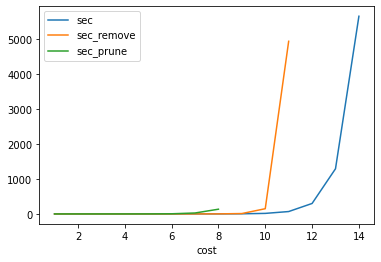

In [15]:
lines = df[['sec', 'sec_remove', 'sec_prune']].plot.line()
"""
如果額外把處理過的state清掉，反而造成太大的時間複雜度
但在不清掉的情況下空間複雜度也會很高（16g ram會爆）
"""

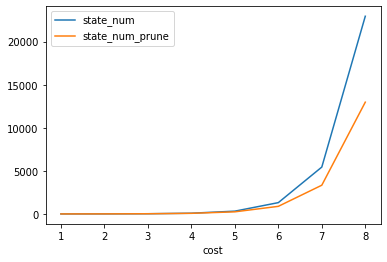

In [19]:
lines = df.iloc[:8][['state_num', 'state_num_prune']].plot.line()

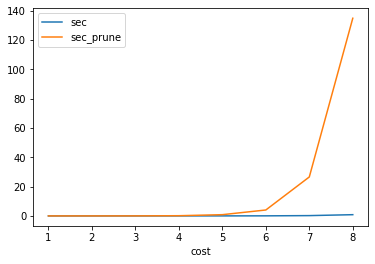

In [20]:
lines = df.iloc[:8][['sec', 'sec_prune']].plot.line()

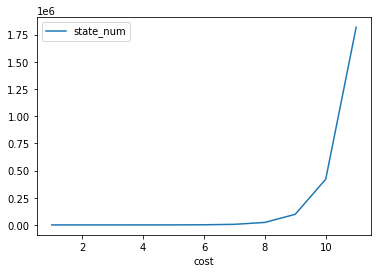

In [15]:
lines = df[['state_num']].plot.line()

### same test case w/ and w/o pruning

In [21]:
df_p = pd.read_csv('stats_pruning.csv')
df_p = df_p.set_index('cost')
df_p = df_p.rename(columns={'sec': 'sec_prune', 'state_num': 'state_num_prune'})

df_p.head()

,sec_prune,state_num_prune
cost,,
1,0.001427,2
2,0.004187,7
3,0.019743,22
4,0.093702,71
5,0.511800,244


In [22]:
df_np = pd.read_csv('stats_no_pruning.csv')
df_np = df_np.set_index('cost')

df_np.head()

,sec,state_num
cost,,
1,0.001327,2
2,0.001660,7
3,0.002180,22
4,0.004455,83
5,0.014559,322


In [29]:
df_case = df_p.merge(df_np, on='cost', how='outer')
df_case.head()

,sec_prune,state_num_prune,sec,state_num
cost,,,,
1,0.001427,2,0.001327,2.0
2,0.004187,7,0.001660,7.0
3,0.019743,22,0.002180,22.0
4,0.093702,71,0.004455,83.0
5,0.511800,244,0.014559,322.0


<AxesSubplot:xlabel='cost'>

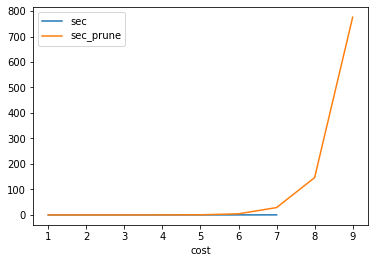

In [32]:
df_case[['sec', 'sec_prune']].plot.line()

### state per second

In [34]:
def state_per_second(csv_path:str):
    df = pd.read_csv(csv_path)
    df['state_per_second'] = df['state_num']/df['sec']
    df = df.set_index('cost')
    df['state_per_second'].plot.line()

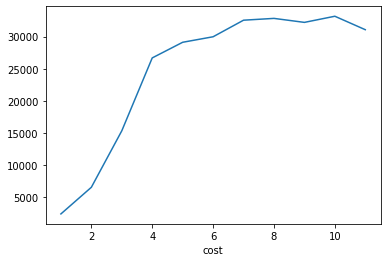

In [35]:
# original (pop and stay)
state_per_second('stats.csv')

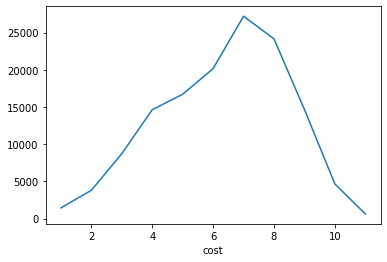

In [38]:
# pop state and remove
state_per_second('stats_remove.csv')

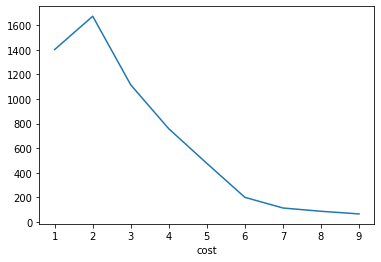

In [36]:
# is_dead + is_redundant
state_per_second('stats_pruning.csv')

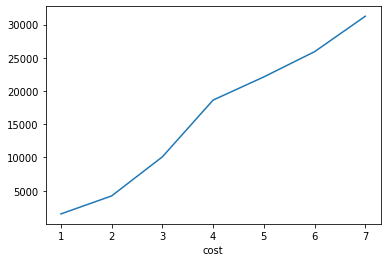

In [37]:
state_per_second('stats_no_pruning.csv')

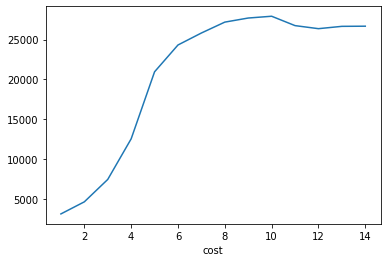

In [39]:
state_per_second('stats_server.csv')

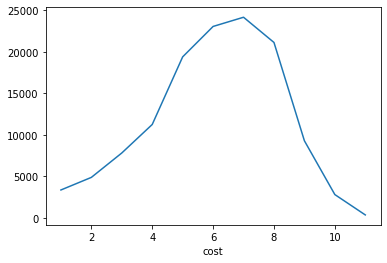

In [40]:
state_per_second('stats_remove_server.csv')

In [41]:
151195055/5665.95

26684.855143444613